# Customer segmentation

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from cluster.cluster_functions import *
from cluster.plotting import *

from sklearn.metrics import pairwise_distances_argmin_min

sns.set()
%load_ext autoreload
%autoreload 2

In [2]:
invoices = pd.read_csv("data/retail/invoices_2009_2011_no_returns.csv", low_memory=False)
invoices['InvoiceDate'] = pd.to_datetime(invoices['InvoiceDate'])
invoices.dropna(inplace=True)

Segmentation is performed on customers who made three or more purchases in the first year (2009-12-1 : 2010-12-1), whilst the resulting clusters are "evaluated" on their second year purchases. Three purchases is just enough to create the aggregation features necessary to cluster on. No information regarding whether a customer's purchase is a repeat purchase (or is their very first purchase) is avaiable.  

In [6]:
cohort_customer_ids = invoices[invoices.InvoiceDate<'2010-12-1'].CustomerID.unique()
cohort_invoices = invoices[invoices.CustomerID.isin(cohort_customer_ids)]
cohort_invoices[cohort_invoices['CustomerID']==13087.0]  # Print transaction history for Customer 10387

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue
26740,491711,85123,WHITE HANGING HEART T-LIGHT HOLDER,18,2009-12-13 15:16:00,2.95,13087.0,United Kingdom,53.10
26741,491711,21463,MIRRORED DISCO BALL,4,2009-12-13 15:16:00,5.95,13087.0,United Kingdom,23.80
26742,491711,85168,WHITE BAROQUE CARRIAGE CLOCK,4,2009-12-13 15:16:00,9.95,13087.0,United Kingdom,39.80
26743,491711,84765,SILVER ROCOCO CANDELABRA,2,2009-12-13 15:16:00,12.75,13087.0,United Kingdom,25.50
26744,491711,22215,CAKE STAND WHITE TWO TIER LACE,2,2009-12-13 15:16:00,8.50,13087.0,United Kingdom,17.00
26745,491711,84750,BLACK SMALL GLASS CAKE STAND,8,2009-12-13 15:16:00,1.95,13087.0,United Kingdom,15.60
26746,491711,22183,CAKE STAND VICTORIAN FILIGREE MED,3,2009-12-13 15:16:00,6.75,13087.0,United Kingdom,20.25
26747,491711,35637,IVORY STRING CURTAIN WITH POLE,2,2009-12-13 15:16:00,5.95,13087.0,United Kingdom,11.90
26748,491711,84707,PINK JEWELLED MIRROR TRINKET TRAY,2,2009-12-13 15:16:00,9.95,13087.0,United Kingdom,19.90
26749,491711,84709,PINK OVAL JEWELLED MIRROR,3,2009-12-13 15:16:00,5.95,13087.0,United Kingdom,17.85


<br>
<br>

# Cluster on RFM features

**KMeans**

In [4]:
features = get_money_aggregation_features(cohort_invoices[cohort_invoices.InvoiceDate<'2010-12-1'])
features = get_rfm_features(features, cohort_invoices[cohort_invoices.InvoiceDate<'2010-12-1'])
features = get_total_first_year_revenue(features, cohort_invoices[cohort_invoices.InvoiceDate<'2010-12-1'])
features = get_second_year_rlv(features, cohort_invoices[cohort_invoices.InvoiceDate>='2010-12-1'])
features.head()

,CustomerID,MedianPurchaseValue,StDevPurchaseValue,MinPurchaseValue,MaxPurchaseValue,SumPurchaseValue,SizePurchaseValue,frequency,recency,T,monetary_value,T_Minus_Recency,TotalFirstYearRevenue,log(1+TotalFirstYearRevenue),SecondYearRLV
0,12346.0,84.68,81.501128,27.05,142.31,169.36,2,1.0,118.0,273.0,142.310,155.0,169.36,5.137914,77183.60
1,12349.0,1110.57,59.467680,1068.52,1152.62,2221.14,2,1.0,182.0,215.0,1152.620,30.0,2221.14,7.706226,1457.55
2,12352.0,171.90,39.810112,143.75,200.05,343.80,2,1.0,17.0,18.0,200.050,64.0,343.80,5.842965,1385.74
3,12356.0,798.44,840.956062,349.85,1977.96,3126.25,3,2.0,44.0,50.0,1163.905,33.0,3126.25,8.047909,2487.43
4,12358.0,821.08,581.088065,268.10,1429.83,2519.01,3,2.0,356.0,357.0,544.590,1.0,2519.01,7.832018,928.06


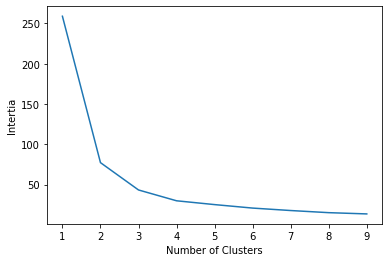

In [5]:
cluster_feats = [
    'recency',
    'frequency',
    'monetary_value'   
]

cluster_elbow_method(features, cluster_feats, scaler='mm')

Inertia for 4 clusters: 29.965882314695747
Cluster labels - 0 = Low value customer, 4 = High value customer
Silhouette Coefficient: 0.5023364240277475
Median 2nd year RLV: [(0, 282.0, 2), (1, 397.0, 2), (2, 716.0, 2), (3, 1736.0, 2)]
Differences: [115.26, 318.56, 1020.44]
Value Counts:
0    584
1    672
2    735
3    756
Name: Cluster, dtype: int64
Explained variance ratio: [0.93689441 0.03653677]
Total explained variance: 0.9734311837519658


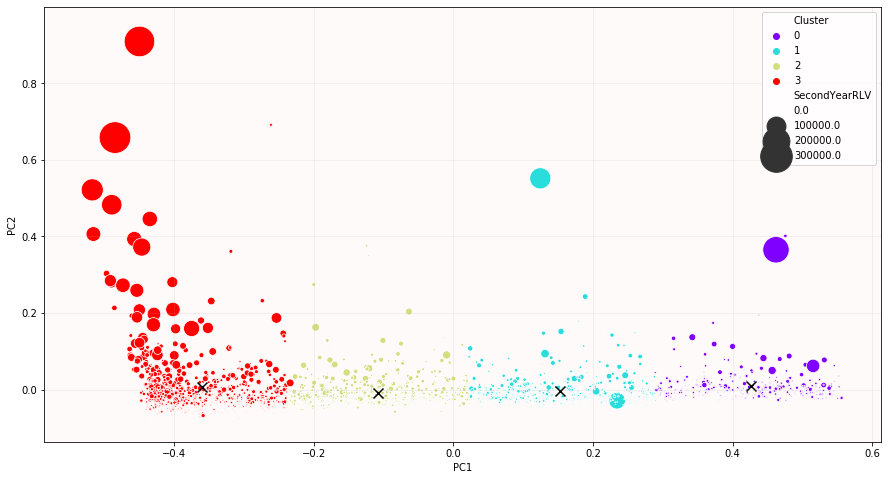

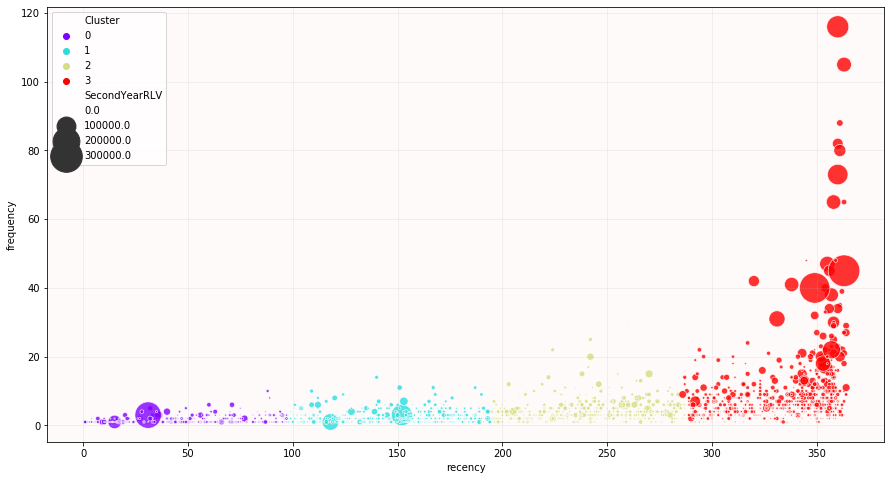

In [6]:
num_clusters = 4
features, scaler, cluster_centers  = perform_km_clustering(features, cluster_feats, num_clusters, scaler='mm')
features, sorted_cluster_centers = reorder_clusters(features, cluster_centers, num_clusters)
evaluate_clusters(features, num_clusters, cluster_feats, scaler)
pca = cluster_pca_plot(features, cluster_feats, scaler, sorted_cluster_centers)
# tsne = cluster_tsne_plot(features, cluster_feats, scaler, perplexity=40)
cluster_rf_plot(features)

<br>
<br>

**GMM**

In [7]:
features = get_money_aggregation_features(cohort_invoices[cohort_invoices.InvoiceDate<'2010-12-1'])
features = get_rfm_features(features, cohort_invoices[cohort_invoices.InvoiceDate<'2010-12-1'])
features = get_total_first_year_revenue(features, cohort_invoices[cohort_invoices.InvoiceDate<'2010-12-1'])
features = get_second_year_rlv(features, cohort_invoices[cohort_invoices.InvoiceDate>='2010-12-1'])
features.head()

,CustomerID,MedianPurchaseValue,StDevPurchaseValue,MinPurchaseValue,MaxPurchaseValue,SumPurchaseValue,SizePurchaseValue,frequency,recency,T,monetary_value,T_Minus_Recency,TotalFirstYearRevenue,log(1+TotalFirstYearRevenue),SecondYearRLV
0,12346.0,84.68,81.501128,27.05,142.31,169.36,2,1.0,118.0,273.0,142.310,155.0,169.36,5.137914,77183.60
1,12349.0,1110.57,59.467680,1068.52,1152.62,2221.14,2,1.0,182.0,215.0,1152.620,30.0,2221.14,7.706226,1457.55
2,12352.0,171.90,39.810112,143.75,200.05,343.80,2,1.0,17.0,18.0,200.050,64.0,343.80,5.842965,1385.74
3,12356.0,798.44,840.956062,349.85,1977.96,3126.25,3,2.0,44.0,50.0,1163.905,33.0,3126.25,8.047909,2487.43
4,12358.0,821.08,581.088065,268.10,1429.83,2519.01,3,2.0,356.0,357.0,544.590,1.0,2519.01,7.832018,928.06


Cluster labels - 0 = Low value customer, 4 = High value customer
Silhouette Coefficient: 0.009011557632945914
Median 2nd year RLV: [(0, 197.0, 2), (1, 598.0, 2), (2, 2567.0, 2), (3, 7831.0, 2)]
Differences: [401.18, 1968.86, 5264.12]
Value Counts:
0     822
1    1220
2     565
3     140
Name: Cluster, dtype: int64
Explained variance ratio: [0.93689441 0.03653677]
Total explained variance: 0.9734311837519661


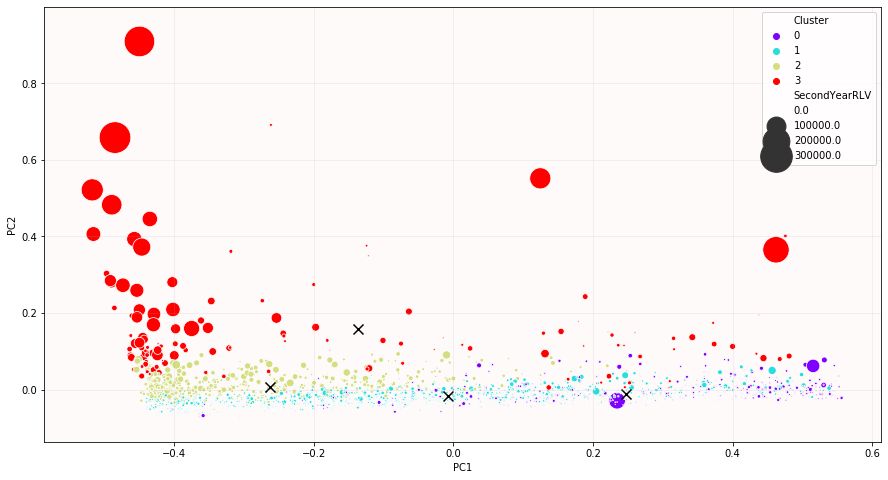

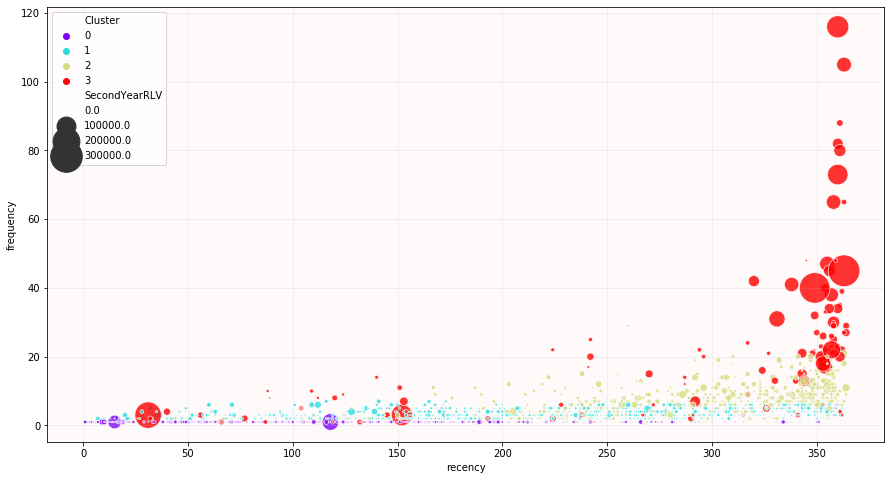

In [8]:
num_clusters = 4
features, scaler, cluster_centers  = perform_gmm_clustering(features, cluster_feats, num_clusters, scaler='mm')
features, sorted_cluster_centers = reorder_clusters(features, cluster_centers, num_clusters)
evaluate_clusters(features, num_clusters, cluster_feats, scaler)
pca = cluster_pca_plot(features, cluster_feats, scaler, sorted_cluster_centers)
# tsne = cluster_tsne_plot(features, cluster_feats, scaler, perplexity=40)
cluster_rf_plot(features)

<br>
<br>

# Cluster on monetary aggregation features

**KMeans**

In [9]:
features = get_money_aggregation_features(cohort_invoices[cohort_invoices.InvoiceDate<'2010-12-1'])
features = get_rfm_features(features, cohort_invoices[cohort_invoices.InvoiceDate<'2010-12-1'])
features = get_total_first_year_revenue(features, cohort_invoices[cohort_invoices.InvoiceDate<'2010-12-1'])
features = get_second_year_rlv(features, cohort_invoices[cohort_invoices.InvoiceDate>='2010-12-1'])

feats_to_transform = [
    'MedianPurchaseValue', # 'MeanPurchaseValue', 
    'StDevPurchaseValue',
    'MinPurchaseValue', 
    'MaxPurchaseValue', 
    'SumPurchaseValue', 
]
features, transformed_feat_names = transform_features(features, feats_to_transform, transform="log")

features.head()

,CustomerID,log(1+MedianPurchaseValue),log(1+StDevPurchaseValue),log(1+MinPurchaseValue),log(1+MaxPurchaseValue),log(1+SumPurchaseValue),SizePurchaseValue,frequency,recency,T,monetary_value,T_Minus_Recency,TotalFirstYearRevenue,log(1+TotalFirstYearRevenue),SecondYearRLV
0,12346.0,4.450619,4.412812,3.333989,4.965010,5.137914,2,1.0,118.0,273.0,142.310,155.0,169.36,5.137914,77183.60
1,12349.0,7.013529,4.102109,6.974965,7.050660,7.706226,2,1.0,182.0,215.0,1152.620,30.0,2221.14,7.706226,1457.55
2,12352.0,5.152713,3.708930,4.975008,5.303554,5.842965,2,1.0,17.0,18.0,200.050,64.0,343.80,5.842965,1385.74
3,12356.0,6.683911,6.735728,5.860359,7.590327,8.047909,3,2.0,44.0,50.0,1163.905,33.0,3126.25,8.047909,2487.43
4,12358.0,6.711838,6.366622,5.595083,7.266010,7.832018,3,2.0,356.0,357.0,544.590,1.0,2519.01,7.832018,928.06


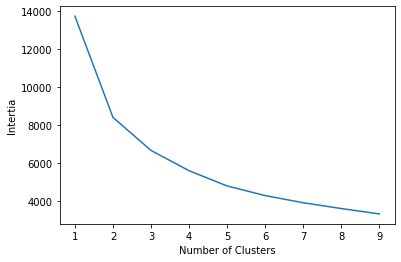

In [10]:
cluster_feats = transformed_feat_names

cluster_elbow_method(features, cluster_feats, scaler='normal')

Inertia for 4 clusters: 5592.783041503733
Cluster labels - 0 = Low value customer, 4 = High value customer
Silhouette Coefficient: 0.3059491262138529
Median 2nd year RLV: [(0, 180.0, 2), (1, 689.0, 2), (2, 1122.0, 2), (3, 3092.0, 2)]
Differences: [509.75, 432.26, 1970.81]
Value Counts:
0     704
1    1316
2     254
3     473
Name: Cluster, dtype: int64
Explained variance ratio: [0.67653049 0.21741091]
Total explained variance: 0.8939413949582043


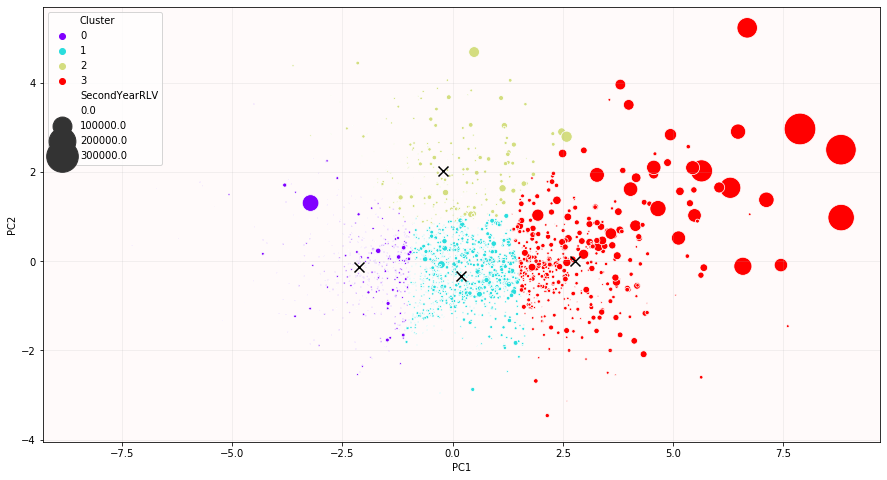

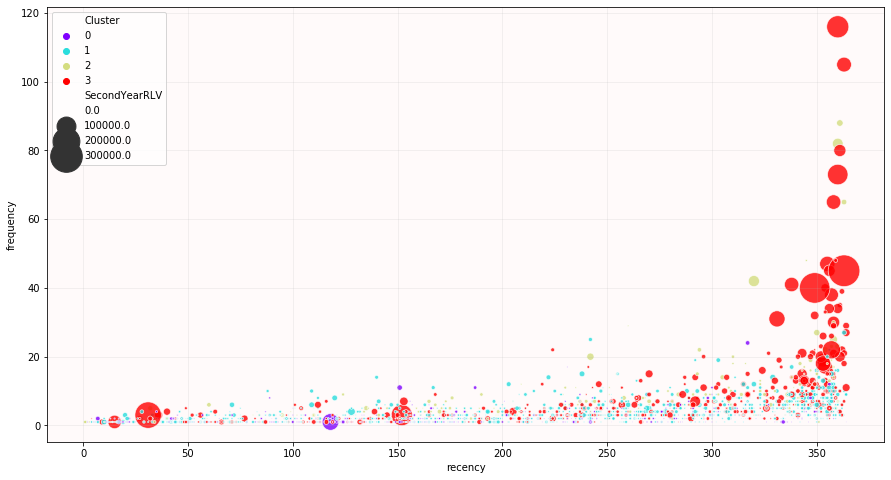

In [11]:
num_clusters = 4
features, scaler, cluster_centers  = perform_km_clustering(features, cluster_feats, num_clusters, scaler='normal')
features, sorted_cluster_centers = reorder_clusters(features, cluster_centers, num_clusters)
evaluate_clusters(features, num_clusters, cluster_feats, scaler)
pca = cluster_pca_plot(features, cluster_feats, scaler, sorted_cluster_centers)
# tsne = cluster_tsne_plot(features, cluster_feats, scaler, perplexity=40, n_iter=2000)
cluster_rf_plot(features)

<br>
<br>

**GMM**

In [12]:
features = get_money_aggregation_features(cohort_invoices[cohort_invoices.InvoiceDate<'2010-12-1'])
features = get_rfm_features(features, cohort_invoices[cohort_invoices.InvoiceDate<'2010-12-1'])
features = get_total_first_year_revenue(features, cohort_invoices[cohort_invoices.InvoiceDate<'2010-12-1'])
features = get_second_year_rlv(features, cohort_invoices[cohort_invoices.InvoiceDate>='2010-12-1'])

feats_to_transform = [
    'MedianPurchaseValue',  # 'MeanPurchaseValue', 
    'StDevPurchaseValue',
    'MinPurchaseValue', 
    'MaxPurchaseValue', 
    'SumPurchaseValue',
    'SizePurchaseValue'
]

features, transformed_feat_names = transform_features(features, feats_to_transform, transform="log")

features.head()

,CustomerID,log(1+MedianPurchaseValue),log(1+StDevPurchaseValue),log(1+MinPurchaseValue),log(1+MaxPurchaseValue),log(1+SumPurchaseValue),log(1+SizePurchaseValue),frequency,recency,T,monetary_value,T_Minus_Recency,TotalFirstYearRevenue,log(1+TotalFirstYearRevenue),SecondYearRLV
0,12346.0,4.450619,4.412812,3.333989,4.965010,5.137914,1.098612,1.0,118.0,273.0,142.310,155.0,169.36,5.137914,77183.60
1,12349.0,7.013529,4.102109,6.974965,7.050660,7.706226,1.098612,1.0,182.0,215.0,1152.620,30.0,2221.14,7.706226,1457.55
2,12352.0,5.152713,3.708930,4.975008,5.303554,5.842965,1.098612,1.0,17.0,18.0,200.050,64.0,343.80,5.842965,1385.74
3,12356.0,6.683911,6.735728,5.860359,7.590327,8.047909,1.386294,2.0,44.0,50.0,1163.905,33.0,3126.25,8.047909,2487.43
4,12358.0,6.711838,6.366622,5.595083,7.266010,7.832018,1.386294,2.0,356.0,357.0,544.590,1.0,2519.01,7.832018,928.06


Cluster labels - 0 = Low value customer, 4 = High value customer
Silhouette Coefficient: 0.039167153234973766
Median 2nd year RLV: [(0, 214.0, 2), (1, 647.0, 2), (2, 925.0, 2), (3, 1920.0, 2)]
Differences: [432.86, 277.93, 995.63]
Value Counts:
0     779
1     433
2    1027
3     508
Name: Cluster, dtype: int64
Explained variance ratio: [0.59949263 0.24658007]
Total explained variance: 0.8460726981572406


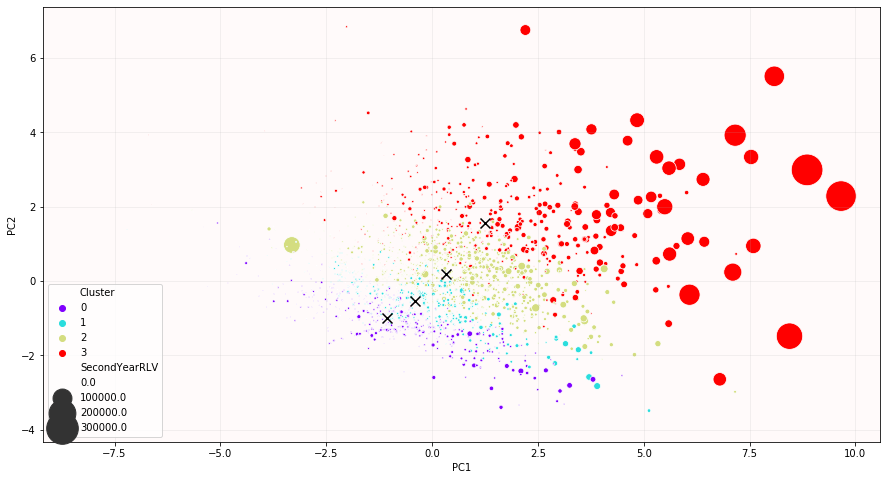

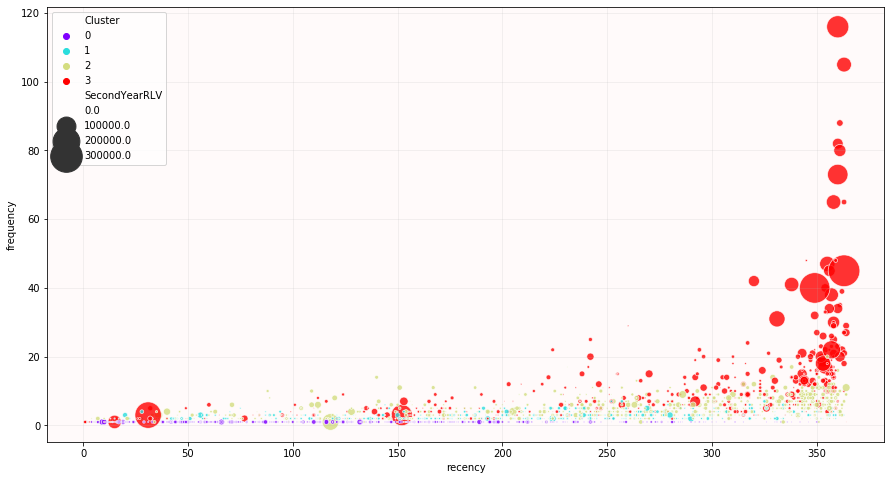

In [13]:
cluster_feats = transformed_feat_names

num_clusters = 4
features, scaler, cluster_centers  = perform_gmm_clustering(features, cluster_feats, num_clusters, scaler='normal')
features, sorted_cluster_centers = reorder_clusters(features, cluster_centers, num_clusters)
evaluate_clusters(features, num_clusters, cluster_feats, scaler)
pca = cluster_pca_plot(features, cluster_feats, scaler, sorted_cluster_centers)
# tsne = cluster_tsne_plot(features, cluster_feats, scaler, perplexity=40, n_iter=2000)
cluster_rf_plot(features)

<br>
<br>

# Pareto

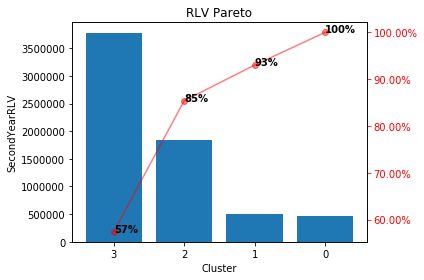

In [14]:
df = features.groupby('Cluster')['SecondYearRLV'].sum().reset_index()
df['Cluster'] = df['Cluster'].astype(str)
pareto_plot(df, x='Cluster', y='SecondYearRLV', show_pct_y=True, title='RLV Pareto')

<br>
<br>

# Cluster statistics and distributions

**Mean Cluster Features**

In [15]:
for cluster in range(num_clusters):
    print(f"Cluster: {cluster}")
    features_copy = features[features.Cluster==cluster].copy()
    for idx, col in enumerate(cluster_feats):
        features_copy[col] = np.exp(features_copy[col]) - 1  # Reverse log transform
        features_copy.rename(columns={col:feats_to_transform[idx]}, inplace=True)
    print(features_copy.mean())
    print()
del features_copy

Cluster: 0
CustomerID                      15289.136072
MedianPurchaseValue               375.015738
StDevPurchaseValue                112.923464
MinPurchaseValue                  295.166791
MaxPurchaseValue                  454.864685
SumPurchaseValue                  750.031476
SizePurchaseValue                   2.000000
frequency                           1.000000
recency                           118.781772
T                                 202.241335
monetary_value                    376.361207
T_Minus_Recency                    85.645700
TotalFirstYearRevenue             750.031476
log(1+TotalFirstYearRevenue)        6.373638
SecondYearRLV                     590.663415
Cluster                             0.000000
dtype: float64

Cluster: 1
CustomerID                      15391.556582
MedianPurchaseValue               386.050000
StDevPurchaseValue                 79.672781
MinPurchaseValue                  309.207598
MaxPurchaseValue                  475.758222
SumPurchaseValue 

**Why log transform?**

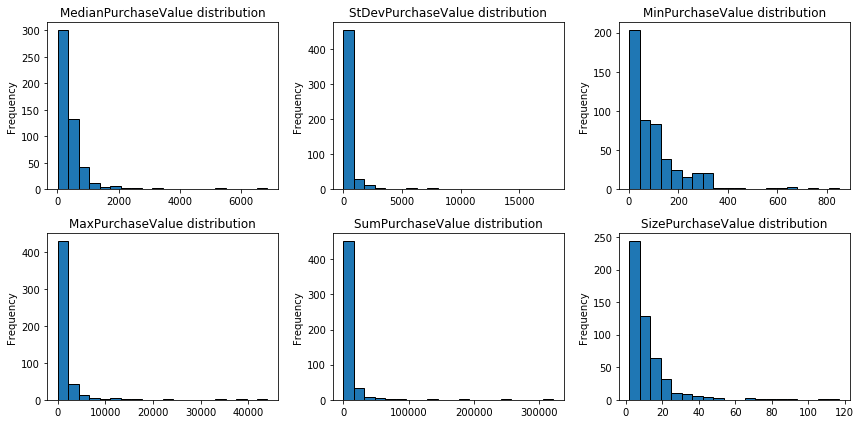

In [16]:
cluster = 3
fig = plt.figure(figsize=(12,6))
for idx, feat in enumerate(cluster_feats):
    ax = fig.add_subplot(2,3,idx+1)
    (np.exp(features[features.Cluster==cluster][feat])-1).plot.hist(bins=20, ax=ax, edgecolor='k')
    ax.set_title(f"{feat[6:-1]} distribution")
plt.tight_layout()

Before log transformations all of the monetary aggregation features are right skewed. This exaggerates the difference between the highest spending customers and those who are also relatively high spenders but don't spend as much which is undesirable. The clustering algorithms won't group these customers together unless the right side of the axis is "squashed" together which the log(1+X) transform achieves.  

<br>
<br>

**Typical Customer**

In [17]:
closest, _ = pairwise_distances_argmin_min(sorted_cluster_centers, scaler.transform(features[cluster_feats]))
closest

array([ 295, 1984, 1640, 1653], dtype=int64)

In [18]:
typical_customers = []
for i, idx in enumerate(closest):
    typical_customers.append(features.iloc[idx].CustomerID)
    features_copy = features.copy()
    for j, col in enumerate(cluster_feats):
        features_copy[col] = np.exp(features_copy[col]) - 1  # Reverse log transform
        features_copy.rename(columns={col:feats_to_transform[j]}, inplace=True)
    print(f"Cluster: {i}")
    print(features_copy.iloc[idx])
    print()
del features_copy

Cluster: 0
CustomerID                      13064.000000
MedianPurchaseValue               280.625000
StDevPurchaseValue                 57.947401
MinPurchaseValue                  239.650000
MaxPurchaseValue                  321.600000
SumPurchaseValue                  561.250000
SizePurchaseValue                   2.000000
frequency                           1.000000
recency                            41.000000
T                                 217.000000
monetary_value                    321.600000
T_Minus_Recency                   176.000000
TotalFirstYearRevenue             561.250000
log(1+TotalFirstYearRevenue)        6.331947
SecondYearRLV                    1119.490000
Cluster                             0.000000
Name: 295, dtype: float64

Cluster: 1
CustomerID                      16625.000000
MedianPurchaseValue               326.875000
StDevPurchaseValue                 53.763144
MinPurchaseValue                  270.000000
MaxPurchaseValue                  397.200000
SumPur

In [19]:
daily_customer_revenues = cohort_invoices.groupby(["CustomerID", pd.Grouper(key='InvoiceDate', freq='D')])['Revenue'].sum().reset_index()
for customer in typical_customers:
    print(daily_customer_revenues[daily_customer_revenues.CustomerID==customer].to_string(index=False))
    print()

 CustomerID InvoiceDate  Revenue
    13064.0  2010-04-27   239.65
    13064.0  2010-06-07   321.60
    13064.0  2011-01-16   203.30
    13064.0  2011-07-10   455.95
    13064.0  2011-09-12   183.08
    13064.0  2011-11-27   277.16

 CustomerID InvoiceDate  Revenue
    16625.0  2010-06-14   270.00
    16625.0  2010-08-16   310.50
    16625.0  2010-09-13   343.25
    16625.0  2010-10-13   397.20
    16625.0  2011-03-10   333.08

 CustomerID InvoiceDate  Revenue
    15916.0  2009-12-10   404.82
    15916.0  2010-01-17   146.81
    15916.0  2010-03-08   332.83
    15916.0  2010-05-30   221.24
    15916.0  2010-11-11   560.93
    15916.0  2010-12-08   232.45
    15916.0  2011-01-13   342.61
    15916.0  2011-04-07   160.12
    15916.0  2011-06-01   113.35
    15916.0  2011-09-23   118.90
    15916.0  2011-11-09   372.28
    15916.0  2011-11-23   188.38

 CustomerID InvoiceDate  Revenue
    15955.0  2010-02-23   389.28
    15955.0  2010-03-11   335.90
    15955.0  2010-05-06   898.45
    159

<br>
<br>